# **Workshop: From electrons to phase diagrams**

# Day 2: Validation of the potentials (draft)

## Import the fitted potentials for Li-Al ( from prevoius excercise)

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import time

In [2]:
time_start =  time.process_time()

time_start

2.426196225

In [3]:
from pyiron_atomistics import Project
import pyiron_gpl
from ase.lattice.compounds import B2
from pyiron_atomistics import ase_to_pyiron

In [4]:
# from structdbrest import StructDBLightRester
# rest = StructDBLightRester(token="workshop2021")

In [5]:
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm, PowerNorm

linewidth = 3
axis_width = linewidth - 1

# Figure parameters
mpl.rcParams["figure.titlesize"] = 38
mpl.rcParams["figure.figsize"] = 10, 8
mpl.rcParams["figure.subplot.wspace"] = 0.6
mpl.rcParams["figure.subplot.hspace"] = 0.6

# Line parameters
mpl.rcParams['lines.linewidth'] = linewidth
mpl.rcParams['lines.markeredgewidth'] = linewidth
mpl.rcParams['lines.markersize'] = linewidth

# Font parameters
#mpl.rcParams['font.family'] = 'Times New Roman'

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 20

# Latex params
#mpl.rcParams['text.usetex'] = True

# Axes parameters
mpl.rcParams['axes.linewidth'] = axis_width
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20

# Tick parameters
mpl.rcParams["xtick.top"] = True
mpl.rcParams["xtick.major.size"] = 2 * linewidth + 1
mpl.rcParams["xtick.minor.size"] = linewidth
mpl.rcParams["xtick.major.width"] = axis_width
mpl.rcParams["xtick.labelsize"] = 20
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.right"] = True
mpl.rcParams["ytick.major.size"] = 2 * linewidth + 1
mpl.rcParams["ytick.minor.size"] = linewidth
mpl.rcParams["ytick.major.width"] = axis_width
mpl.rcParams["ytick.labelsize"] = 20
mpl.rcParams["ytick.direction"] = "in"

# Grid parameters
mpl.rcParams["grid.linewidth"] = axis_width       ## in points

# Legend parameters
mpl.rcParams["legend.framealpha"] = 1
mpl.rcParams["legend.edgecolor"] = "k"
mpl.rcParams["legend.fancybox"] = False
mpl.rcParams["legend.fontsize"] = 20

# Mathtext parameters parameters
mpl.rcParams["mathtext.fontset"] = "stix"

#del mpl.font_manager.weight_dict['roman']
#mpl.font_manager._rebuild()

In [6]:
pr = Project("validation_test")
####pr.remove_jobs(silently=True, recursive=True)

In [7]:
##########! rm -rf validation_test

## Generate list of potentials (after fitting)

In [8]:
dummy = pr.create.job.Lammps("dummy")
dummy.structure = pr.create_ase_bulk("Al", cubic=True)
dummy.structure[0] = "Ni"
potential_list = dummy.list_potentials()[:3]

In [9]:
potential_list

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '2002--Mishin-Y--Ni-Al--LAMMPS--ipr1',
 '2004--Mishin-Y--Ni-Al--LAMMPS--ipr1']

## Iterate over all potentials and all possible phases

In [10]:
struct_dict = dict()
struct_dict["Al"] = dict()
struct_dict["Al"]["s_murn"] = ["fcc", "bcc", "sc"]
struct_dict["Al"]["a"] = 4.04

struct_dict["Ni"] = dict()
struct_dict["Ni"]["s_murn"] = ["fcc", "bcc", "sc"]
struct_dict["Ni"]["a"] = 3.5


struct_dict["NiAl"] = dict()
struct_dict["NiAl"]["s_murn"] = ["B2"]
struct_dict["NiAl"]["a"] = 3.7



struct_dict

{'Al': {'s_murn': ['fcc', 'bcc', 'sc'], 'a': 4.04},
 'Ni': {'s_murn': ['fcc', 'bcc', 'sc'], 'a': 3.5},
 'NiAl': {'s_murn': ['B2'], 'a': 3.7}}

In [11]:
def clean_project_name(name):
    return name.replace("-", "_").replace(".", "_")

### Ground state: E-V curves

In [12]:
for pot in potential_list:
    with pr.open(clean_project_name(pot)) as pr_pot:
        for compound, compound_dict in struct_dict.items():
            for crys_structure in compound_dict["s_murn"]:
                
                # Relax structure
                if crys_structure == "B2":
                    basis = ase_to_pyiron(B2(["Ni", "Al"], latticeconstant=compound_dict["a"]))
                else:
                    basis = pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])
                job_relax = pr_pot.create_job(pr_pot.job_type.Lammps, f"{compound}_{crys_structure}_relax", delete_existing_job=True)

                job_relax.structure = basis
                job_relax.potential = pot
                job_relax.calc_minimize(pressure=0)
                job_relax.run()
                
                # Murnaghan
                job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, f"ref_job_{compound}_{crys_structure}")
                job_ref.structure = job_relax.get_structure(-1)
                job_ref.potential = pot
                job_ref.calc_minimize()
                murn_job = job_ref.create_job(pr_pot.job_type.Murnaghan, f"murn_job_{compound}_{crys_structure}")
                murn_job.input["vol_range"] = 0.1
                murn_job.run()

The job Al_fcc_relax was saved and received the ID: 16677135
The job murn_job_Al_fcc was saved and received the ID: 16677136
The job murn_job_Al_fcc_0_9 was saved and received the ID: 16677137
The job murn_job_Al_fcc_0_92 was saved and received the ID: 16677138
The job murn_job_Al_fcc_0_94 was saved and received the ID: 16677139
The job murn_job_Al_fcc_0_96 was saved and received the ID: 16677140
The job murn_job_Al_fcc_0_98 was saved and received the ID: 16677141
The job murn_job_Al_fcc_1_0 was saved and received the ID: 16677142
The job murn_job_Al_fcc_1_02 was saved and received the ID: 16677143
The job murn_job_Al_fcc_1_04 was saved and received the ID: 16677144
The job murn_job_Al_fcc_1_06 was saved and received the ID: 16677145
The job murn_job_Al_fcc_1_08 was saved and received the ID: 16677146
The job murn_job_Al_fcc_1_1 was saved and received the ID: 16677147
The job Al_bcc_relax was saved and received the ID: 16677148
The job murn_job_Al_bcc was saved and received the ID: 166

In [13]:
##pr.remove_jobs(recursive=True)

In [14]:
# Define functions to get data

# Only work with Murnaghan jobs
def get_only_murn(job_table):
    return (job_table.hamilton == "Murnaghan") & (job_table.status == "finished") 

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path.project.path.split("/")[-3]

def get_eq_energy(job_path):
    return job_path["output/equilibrium_energy"]

def get_n_atoms(job_path):
    return len(job_path["output/structure/positions"])


def get_potential(job_path):
    return job_path.project.path.split("/")[-2]

def get_crystal_structure(job_path):
    return job_path.job_name.split("_")[-1]

def get_compound(job_path):
    return job_path.job_name.split("_")[-2]

In [15]:
# Compile data using pyiron tables
table = pr.create_table("table_murn", delete_existing_job=True)
table.convert_to_object = True
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm
table.add["eq_energy"] = get_eq_energy
table.add["n_atoms"] = get_n_atoms
table.run()
data_murn = table.get_dataframe()

The job table_murn was saved and received the ID: 16677416


Loading and filtering jobs:   0%|          | 0/21 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/21 [00:00<?, ?it/s]

In [16]:
pr.job_table(status="finished");

## Elastic constants and Phonons

In [17]:
for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    print(pot)
    
    for _, row in data_murn[data_murn.potential==group_name].iterrows():
        job_id = row.job_id
        
        job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, f"ref_job_{row.compound}_{row.crystal_structure}")
        ref = pr_pot.load(job_id)
        job_ref.structure = ref.structure
        job_ref.potential = pot
        job_ref.calc_minimize()
        elastic_job = job_ref.create_job(pr_pot.job_type.ElasticMatrixJob, f"elastic_job_{row.compound}_{row.crystal_structure}")
        elastic_job.input["eps_range"] = 0.05
        elastic_job.run()
        
        
        phonopy_job = job_ref.create_job(pr_pot.job_type.PhonopyJob, f"phonopy_job_{row.compound}_{row.crystal_structure}")
        job_ref.calc_static()
        phonopy_job.run()

1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1
The job elastic_job_Al_fcc was saved and received the ID: 16677419
The job s_e_0 was saved and received the ID: 16677420
The job s_01_e_m0_05000 was saved and received the ID: 16677421
The job s_01_e_m0_02500 was saved and received the ID: 16677422
The job s_01_e_0_02500 was saved and received the ID: 16677423
The job s_01_e_0_05000 was saved and received the ID: 16677424
The job s_08_e_m0_05000 was saved and received the ID: 16677425
The job s_08_e_m0_02500 was saved and received the ID: 16677426
The job s_08_e_0_02500 was saved and received the ID: 16677427
The job s_08_e_0_05000 was saved and received the ID: 16677428
The job s_23_e_m0_05000 was saved and received the ID: 16677429
The job s_23_e_m0_02500 was saved and received the ID: 16677430
The job s_23_e_0_02500 was saved and received the ID: 16677431
The job s_23_e_0_05000 was saved and received the ID: 16677432
The job phonopy_job_Al_fcc was saved and received the ID: 16677433
The job re

In [18]:
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

# Get corresponding lattice constants
def get_c11(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return job_path["output/elasticmatrix"]["C"][3, 3]

In [19]:
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure

table.run()
data_elastic = table.get_dataframe()
data_elastic

The job table_elastic was saved and received the ID: 16677758


Loading and filtering jobs:   0%|          | 0/21 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/21 [00:00<?, ?it/s]

,job_id,potential,C11,C12,C44,compound,crystal_structure
0,16677419,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,106.911467,69.255148,30.431795,Al,fcc
1,16677435,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,37.182823,69.500184,8.164544,Al,bcc
2,16677451,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,143.679178,76.980424,5.955743,Al,sc
3,16677467,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,241.409634,159.289244,123.327959,Ni,fcc
4,16677483,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,92.522127,155.137627,99.311026,Ni,bcc
5,16677499,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,383.279308,70.849396,-20.996755,Ni,sc
6,16677515,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,211.238892,194.933767,173.145582,NiAl,B2
7,16677532,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,148.436993,62.156106,81.370388,Al,fcc
8,16677548,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,27.653061,65.719354,76.312964,Al,bcc
9,16677564,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,211.199570,0.788820,-12.844562,Al,sc


### Visualization of the results

In [20]:
data_murn

,job_id,potential,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms
0,16677136,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Al,fcc,4.050000,16.606962,81.040445,-3.360099,1
1,16677149,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Al,bcc,4.124560,19.125925,65.638536,-3.272304,1
2,16677162,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Al,sc,3.825505,19.795529,93.278691,-3.311557,1
3,16677175,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Ni,fcc,3.520000,10.903140,184.675690,-4.450159,1
4,16677188,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Ni,bcc,3.510011,11.767642,137.936343,-4.372803,1
5,16677202,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Ni,sc,3.350192,13.286747,181.269821,-3.974845,1
6,16677216,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,NiAl,B2,4.048878,23.466248,191.838019,-8.851296,2
7,16677229,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,Al,fcc,4.051526,16.632938,95.999778,-3.361936,1
8,16677242,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,Al,bcc,4.025298,17.746010,51.011467,-3.279029,1
9,16677255,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,Al,sc,3.899182,20.956057,68.928830,-2.947367,1


In [21]:
data_elastic

,job_id,potential,C11,C12,C44,compound,crystal_structure
0,16677419,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,106.911467,69.255148,30.431795,Al,fcc
1,16677435,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,37.182823,69.500184,8.164544,Al,bcc
2,16677451,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,143.679178,76.980424,5.955743,Al,sc
3,16677467,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,241.409634,159.289244,123.327959,Ni,fcc
4,16677483,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,92.522127,155.137627,99.311026,Ni,bcc
5,16677499,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,383.279308,70.849396,-20.996755,Ni,sc
6,16677515,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,211.238892,194.933767,173.145582,NiAl,B2
7,16677532,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,148.436993,62.156106,81.370388,Al,fcc
8,16677548,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,27.653061,65.719354,76.312964,Al,bcc
9,16677564,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,211.199570,0.788820,-12.844562,Al,sc


In [22]:
df_ground_state = pd.merge(on=["potential", "compound", "crystal_structure"], left=data_murn, right=data_elastic, suffixes=('_murn', '_elastic'))
df_ground_state["phase"] = df_ground_state.compound + "_" + df_ground_state.crystal_structure
df_ground_state

,job_id_murn,potential,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,job_id_elastic,C11,C12,C44,phase
0,16677136,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Al,fcc,4.050000,16.606962,81.040445,-3.360099,1,16677419,106.911467,69.255148,30.431795,Al_fcc
1,16677149,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Al,bcc,4.124560,19.125925,65.638536,-3.272304,1,16677435,37.182823,69.500184,8.164544,Al_bcc
2,16677162,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Al,sc,3.825505,19.795529,93.278691,-3.311557,1,16677451,143.679178,76.980424,5.955743,Al_sc
3,16677175,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Ni,fcc,3.520000,10.903140,184.675690,-4.450159,1,16677467,241.409634,159.289244,123.327959,Ni_fcc
4,16677188,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Ni,bcc,3.510011,11.767642,137.936343,-4.372803,1,16677483,92.522127,155.137627,99.311026,Ni_bcc
5,16677202,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,Ni,sc,3.350192,13.286747,181.269821,-3.974845,1,16677499,383.279308,70.849396,-20.996755,Ni_sc
6,16677216,1995__Angelo_J_E__Ni_Al_H__LAMMPS__ipr1,NiAl,B2,4.048878,23.466248,191.838019,-8.851296,2,16677515,211.238892,194.933767,173.145582,NiAl_B2
7,16677229,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,Al,fcc,4.051526,16.632938,95.999778,-3.361936,1,16677532,148.436993,62.156106,81.370388,Al_fcc
8,16677242,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,Al,bcc,4.025298,17.746010,51.011467,-3.279029,1,16677548,27.653061,65.719354,76.312964,Al_bcc
9,16677255,2002__Mishin_Y__Ni_Al__LAMMPS__ipr1,Al,sc,3.899182,20.956057,68.928830,-2.947367,1,16677564,211.199570,0.788820,-12.844562,Al_sc


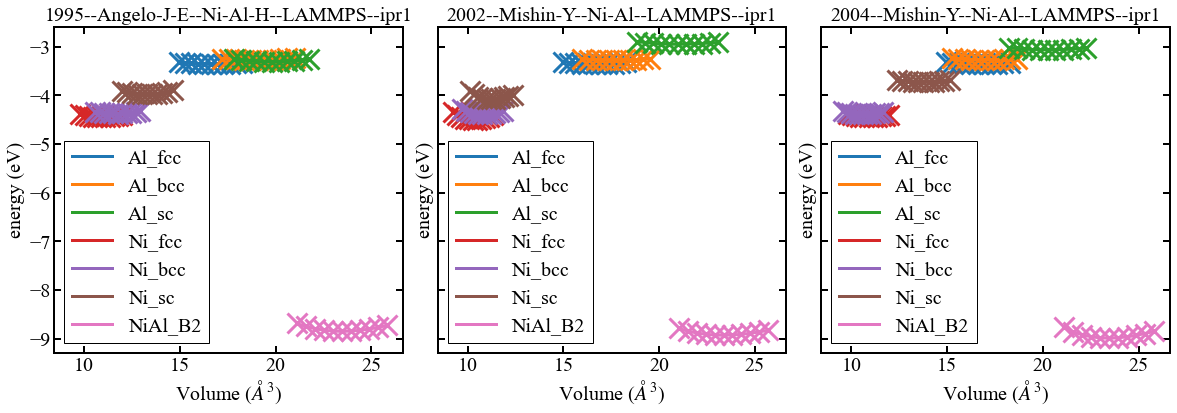

In [23]:
fig, ax_list = plt.subplots(ncols=len(potential_list), nrows=1, sharex="row", sharey="row")

fig.set_figwidth(20)
fig.set_figheight(6)

color_palette = sns.color_palette("tab10", n_colors=len(df_ground_state.phase.unique()))


for i, pot in enumerate(potential_list):
    
    ax = ax_list[i]
    data = df_ground_state[df_ground_state.potential == clean_project_name(pot)]
    
    for j, (_, row) in enumerate(data.iterrows()):
        
        ax = pr.load(row.job_id_murn).plot(plt_show=False, ax=ax, plot_kwargs={"label": row.phase, "color": color_palette[j]})
    
    ax.set_title(f"{pot}")
    #break
fig.subplots_adjust(wspace=0.1);

In [24]:
# fig, ax_list = plt.subplots(ncols=len(potential_list), nrows=1, sharex="row", sharey="row")

# fig.set_figwidth(20)
# fig.set_figheight(6)

# color_palette = sns.color_palette("tab10", n_colors=len(df_ground_state.phase.unique()))


# for i, pot in enumerate(potential_list):
    
#     ax = ax_list[i]
#     data = df_ground_state[df_ground_state.potential == clean_project_name(pot)]
    
#     for j, (_, row) in enumerate(data.iterrows()):
        
#         ax = pr.load(row.job_id_murn).plot(plt_show=False, ax=ax, plot_kwargs={"label": f"phase_{j}", "color": color_palette[j]})
    
#     ax.set_title(f"Potential {i}")
#     #break
# fig.subplots_adjust(wspace=0.1);
# plt.savefig("example.jpeg", bbox_inches="tight");

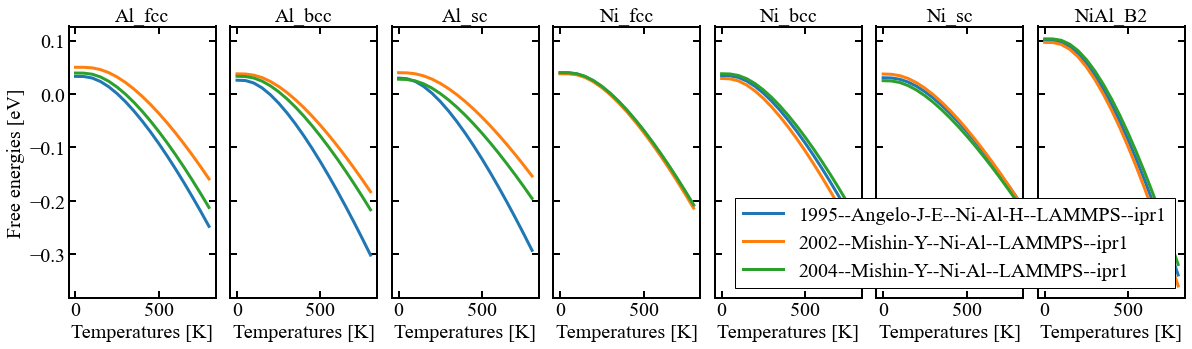

In [25]:
fig, ax_list = plt.subplots(ncols=len(df_ground_state.phase.unique()), nrows=1, sharex="row", sharey="row")

fig.set_figwidth(20)
fig.set_figheight(5)

color_palette = sns.color_palette("tab10", n_colors=len(df_ground_state.potential.unique()))


for i, phase in enumerate(df_ground_state.phase.unique()):
    
    ax = ax_list[i]
    data = df_ground_state[df_ground_state.phase == phase]
    
    
    
    for j, pot in enumerate(potential_list):
        
        phonopy_job = pr[clean_project_name(pot) + f"/phonopy_job_{phase}"]
    
        thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)

        ax.plot(thermo.temperatures, thermo.free_energies, label=pot, color=color_palette[j])
        ax.set_xlabel("Temperatures [K]")
    ax.set_title(f"{phase}")
ax_list[0].set_ylabel("Free energies [eV]")

ax_list[-1].legend()
fig.subplots_adjust(wspace=0.1);

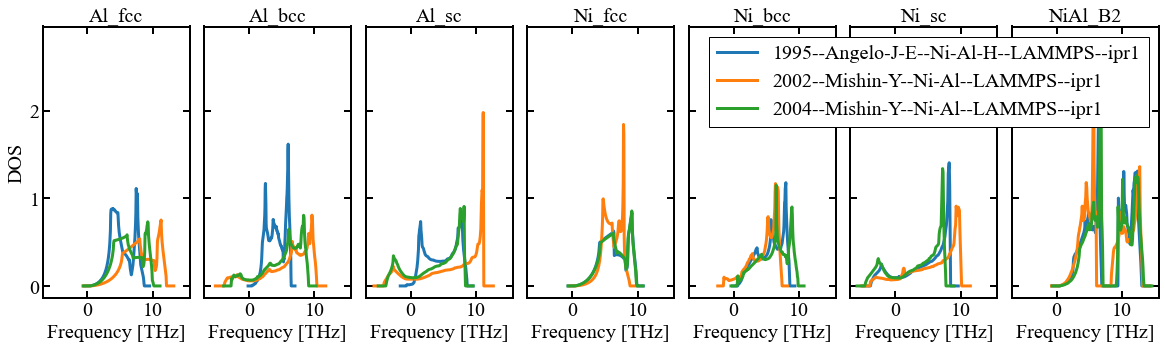

In [26]:
fig, ax_list = plt.subplots(ncols=len(df_ground_state.phase.unique()), nrows=1, sharex="row", sharey="row")

fig.set_figwidth(20)
fig.set_figheight(5)

color_palette = sns.color_palette("tab10", n_colors=len(df_ground_state.potential.unique()))


for i, phase in enumerate(df_ground_state.phase.unique()):
    
    ax = ax_list[i]
    data = df_ground_state[df_ground_state.phase == phase]
    
    
    
    for j, pot in enumerate(potential_list):
        
        phonopy_job = pr[clean_project_name(pot) + f"/phonopy_job_{phase}"]
    
        thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
        
        ax.plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], color=color_palette[j], label=pot)
        ax.set_xlabel("Frequency [THz]")
    ax.set_title(f"{phase}")
ax_list[0].set_ylabel("DOS")

ax_list[-1].legend()
fig.subplots_adjust(wspace=0.1);

In [27]:
# phonopy_job.plot_band_structure()

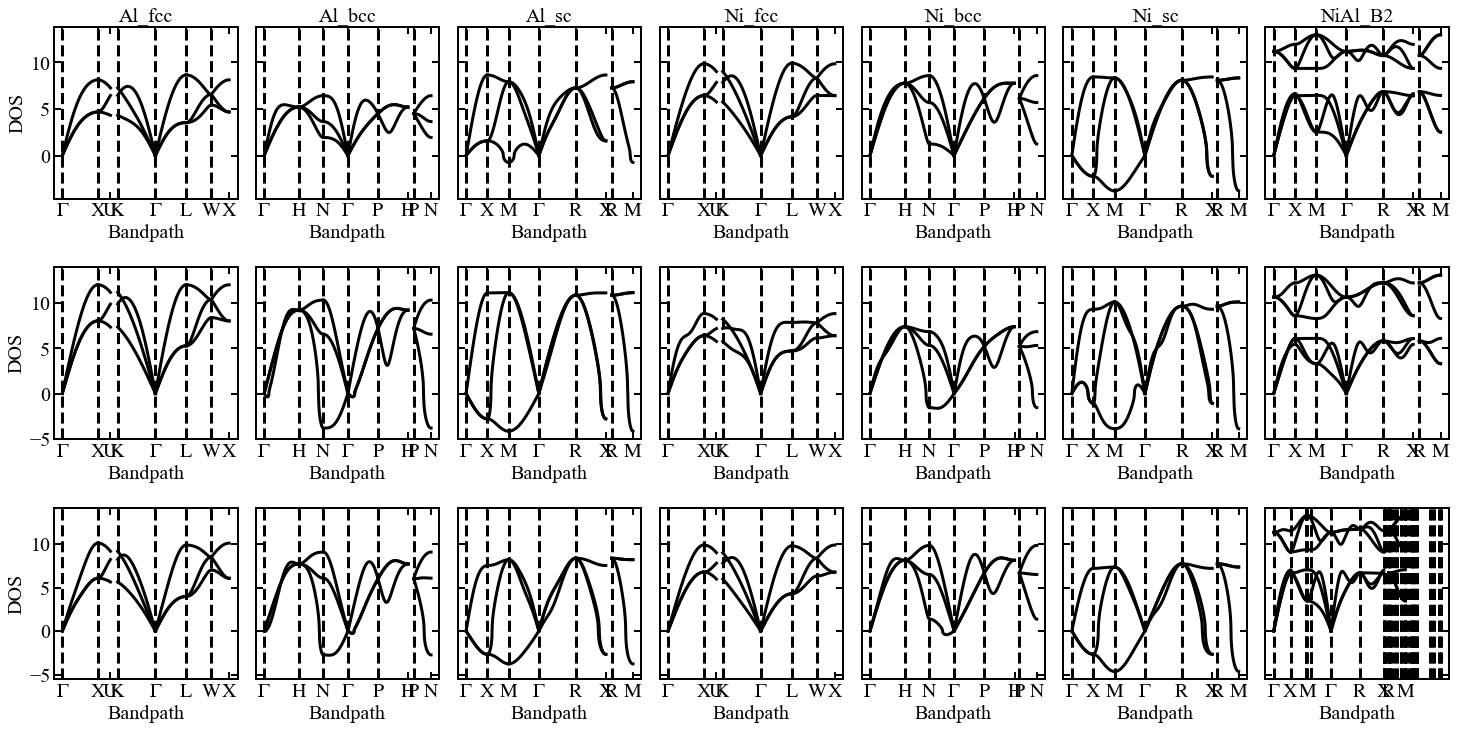

In [28]:
fig, ax_list = plt.subplots(ncols=len(df_ground_state.phase.unique()), nrows=len(potential_list), sharey="row")

fig.set_figwidth(25)
fig.set_figheight(12)

color_palette = sns.color_palette("tab10", n_colors=len(df_ground_state.potential.unique()))


for i, phase in enumerate(df_ground_state.phase.unique()):
    
    
    data = df_ground_state[df_ground_state.phase == phase]
    
    
    
    for j, pot in enumerate(potential_list):
        ax = ax_list[j][i]
        phonopy_job = pr[clean_project_name(pot) + f"/phonopy_job_{phase}"]
    
        phonopy_job.plot_band_structure(axis=ax)
        ax.set_ylabel("")
        ax.set_title("")
        ax_list[j][0].set_ylabel("DOS")
    ax_list[0][i].set_title(f"{phase}")
fig.subplots_adjust(wspace=0.1, hspace=0.4);

In [29]:
time_stop = time.process_time()
print(f"Total run time for the notebook {time_stop - time_start} seconds")

Total run time for the notebook 411.289093237 seconds


Todo:

    - SQS and intermediate ordered phases, layered phases (supply the structures)
    - Properties of compounds
    - Split the workflows into several notebooks
    - Defect formation energies etc.
    - Link to Sarath's part?? (Thermal expansion using MD/QHA)
    - Showing that MD works with these potentials